# Background																			

- 1	The adjacent 3 tabs contain a data dump of search strings used by EXP clients to access relevant content available on Gartner.com for the months of August, September and October in the year 2018. Every row mentions if the EXP client is "Premium" or not, Persona (that was used for data extraction for EXP clients from main database), day on which the search string was used and finally the search string. In total there are 68544 rows of data available across all the months.																		
## Task 1																			

- 2	Clean the dataset using standard text cleaning steps and process the data to allow for the following analysis.																		
- 3	Identify the most popular topics being searched for by EXP clients and plot the top 10 topics by their frequency of occurrence.																		

- 4	Report on the volume growth of these topics over August, September and October.																		
## Task 2																			

- 5	Used the cleaned dataset from Step 2 and process your dataset for the following analysis. 																		
- 6	Use the concept of Named Entity Recognition in your code to identify a list of geographies and organizations being mentioned in the search terms.																		

- 7	Plot the geographies and organizations by their frequency of occurrence (count 1 mention of a geography, if the same geography is mentioned more than once in the same search string). If you can do it for the mention of "technologies" such as ai, analytics etc. then it will be a plus. Any useful trends observed in these mentions of geographies, organizations and technologies should be plotted and presented.																		

# Final Output & Next Steps																			

- 8	"Final output of the exercise should include

 *1. 3 Code files- 1 used for data cleaning and 2 used for each of the 2 tasks (with data processing and data analysis). Please comment your code appropriately. You will be evaluated for properly structuring your code and for building checks and balances in your analysis- which should be included in your code as well.*

 *2. If some data visualization tool such as Tableau/PowerBI is used for presentation of the plots in the panel round (if selected) then it will be considered a plus for the candidate. PPT presentation is acceptable though. The following visualizations are required- *

**- Please prepare 1-2 slides to explain your data cleaning and processing steps, 1-2 slides to display the results of Task 1 (include the methodology used for completing the task), 1-2 slides to display the result of Task 2 (include the methodology used for completing the task), 1-2 slides on what other analysis is possible on the data set including the expected insights from those (for this you will need to mention the preferred methodology for text analysis). "**																		
- 9	You will be given a time limit of 3 Days from the time this test is given, to prepare the output. The candidates should upload the output docs- Dashboard/PPT & their 3 code files in a G-drive link and send them across to the assigned recruiter.																		
- 10	If your output gets selected, you will be asked to present your findings & approach to our panel of experts who would cross question you on your analysis.																		


In [1]:
import numpy as np
import pandas as pd

#for text processing
import re
import string
import nltk 
from nltk.corpus import stopwords
from textblob import Word

#calculation of time
from time import time

##pretty print
import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

from gensim.corpora import Dictionary

# Build LDA model
from gensim.models.ldamulticore import LdaMulticore

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

# spacy 
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('max_colwidth', -1)

C:\Users\tshrs\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


#### Merge all 3 sheets

In [2]:
# from pandas import ExcelWriter
# from pandas import ExcelFile

xls = pd.ExcelFile('data.xlsx')
df1 = pd.read_excel(xls, sheet_name='Aug')
df2 = pd.read_excel(xls, sheet_name='Sept')
df3 = pd.read_excel(xls, sheet_name='Oct')

In [3]:
df = pd.concat([df1,df2,df3] , ignore_index=True)

## Inspect Text field

In [4]:
df.head()

,Is Premium Client,Persona,Search Day,Query Text
0,N,EXP,2018-08-01,adopt 10 best practices to become a contract negotiation expert for data integration tools
1,Y,EXP,2018-08-01,"""security gaps"""
2,Y,EXP,2018-08-01,it service management process maps
3,Y,EXP,2018-08-01,project managment mission
4,Y,EXP,2018-08-01,monitor hardware requirements


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131185 entries, 0 to 131184
Data columns (total 4 columns):
Is Premium Client    131185 non-null object
Persona              131185 non-null object
Search Day           131185 non-null datetime64[ns]
Query Text           131178 non-null object
dtypes: datetime64[ns](1), object(3)
memory usage: 4.0+ MB


In [6]:
df.isnull().sum()

Is Premium Client    0
Persona              0
Search Day           0
Query Text           7
dtype: int64

In [7]:
#fetch missing values of a column

df[df["Query Text"].isnull()]

,Is Premium Client,Persona,Search Day,Query Text
19280,Y,EXP,2018-08-05,NaN
20741,Y,EXP,2018-08-28,NaN
31605,Y,EXP,2018-08-30,NaN
64864,Y,EXP,2018-09-20,NaN
79906,Y,EXP,2018-09-26,NaN
110021,Y,EXP,2018-10-16,NaN
130664,Y,EXP,2018-10-28,NaN


In [8]:
#drop all the rows which have NaN in Query Text

df = df.dropna(how='any',axis=0) 

In [9]:
df.isnull().sum()

Is Premium Client    0
Persona              0
Search Day           0
Query Text           0
dtype: int64

In [10]:
df.drop_duplicates(subset ="Query Text", 
                     keep = 'last', inplace = True) 

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74819 entries, 0 to 131184
Data columns (total 4 columns):
Is Premium Client    74819 non-null object
Persona              74819 non-null object
Search Day           74819 non-null datetime64[ns]
Query Text           74819 non-null object
dtypes: datetime64[ns](1), object(3)
memory usage: 2.9+ MB


In [12]:
# check the length of documents

document_lengths = np.array(list(map(len, df['Query Text'].str.split(' '))))

print("The average number of words in a document is: {}.".format(np.mean(document_lengths)))
print("The minimum number of words in a document is: {}.".format(min(document_lengths)))
print("The maximum number of words in a document is: {}.".format(max(document_lengths)))

The average number of words in a document is: 3.753351421430385.
The minimum number of words in a document is: 1.
The maximum number of words in a document is: 65.


In [13]:
print("There are {} documents with tops 5 words.".format(sum(document_lengths == 1)))
print("There are {} documents with tops 5 words.".format(sum(document_lengths == 2)))
print("There are {} documents with tops 5 words.".format(sum(document_lengths == 3)))
print("There are {} documents with tops 5 words.".format(sum(document_lengths == 4)))
print("There are {} documents with tops 5 words.".format(sum(document_lengths == 5)))

There are 11451 documents with tops 5 words.
There are 18623 documents with tops 5 words.
There are 17085 documents with tops 5 words.
There are 9383 documents with tops 5 words.
There are 5105 documents with tops 5 words.


## Task 1
  
### Sub-task 2 : Text pre-processing

In [14]:
def text_preprocessing(data):
    
    #convert text to lower-case
    data['processed_text'] = data['Query Text'].apply(lambda x:' '.join(x.lower() for x in x.split()))

    #remove punctuations, unwanted characters
    data['processed_text_1']= data['processed_text'].apply(lambda x: "".join([char for char in x if char not in string.punctuation]))

    #remove numbers
    data['processed_text_2']= data['processed_text_1'].apply(lambda x: re.sub('[0-9]+', ' ' , x))

    #remove stopwords
    stop = stopwords.words('english')
    data['processed_text_3']= data['processed_text_2'].apply(lambda x:' '.join(x for x in x.split() if not x in stop))

    #lemmatization
    data['processed_text_4']= data['processed_text_3'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

    # remove all single characters
    data['processed_text_5'] = data['processed_text_4'].apply(lambda x: re.sub(r'\s+[a-zA-Z]\s+', ' ', x))
    
    #create a final text field to work on
    data['final_text'] = data['processed_text_5']

In [15]:
#pre-processing or cleaning data

text_preprocessing(df)

df.head()

,Is Premium Client,Persona,Search Day,Query Text,processed_text,processed_text_1,processed_text_2,processed_text_3,processed_text_4,processed_text_5,final_text
0,N,EXP,2018-08-01,adopt 10 best practices to become a contract negotiation expert for data integration tools,adopt 10 best practices to become a contract negotiation expert for data integration tools,adopt 10 best practices to become a contract negotiation expert for data integration tools,adopt best practices to become a contract negotiation expert for data integration tools,adopt best practices become contract negotiation expert data integration tools,adopt best practice become contract negotiation expert data integration tool,adopt best practice become contract negotiation expert data integration tool,adopt best practice become contract negotiation expert data integration tool
1,Y,EXP,2018-08-01,"""security gaps""","""security gaps""",security gaps,security gaps,security gaps,security gap,security gap,security gap
2,Y,EXP,2018-08-01,it service management process maps,it service management process maps,it service management process maps,it service management process maps,service management process maps,service management process map,service management process map,service management process map
3,Y,EXP,2018-08-01,project managment mission,project managment mission,project managment mission,project managment mission,project managment mission,project managment mission,project managment mission,project managment mission
4,Y,EXP,2018-08-01,monitor hardware requirements,monitor hardware requirements,monitor hardware requirements,monitor hardware requirements,monitor hardware requirements,monitor hardware requirement,monitor hardware requirement,monitor hardware requirement


In [16]:
#create tokenized data for LDA

df['final_tokenized'] = list(map(nltk.word_tokenize, df.final_text))

df.head()

,Is Premium Client,Persona,Search Day,Query Text,processed_text,processed_text_1,processed_text_2,processed_text_3,processed_text_4,processed_text_5,final_text,final_tokenized
0,N,EXP,2018-08-01,adopt 10 best practices to become a contract negotiation expert for data integration tools,adopt 10 best practices to become a contract negotiation expert for data integration tools,adopt 10 best practices to become a contract negotiation expert for data integration tools,adopt best practices to become a contract negotiation expert for data integration tools,adopt best practices become contract negotiation expert data integration tools,adopt best practice become contract negotiation expert data integration tool,adopt best practice become contract negotiation expert data integration tool,adopt best practice become contract negotiation expert data integration tool,"[adopt, best, practice, become, contract, negotiation, expert, data, integration, tool]"
1,Y,EXP,2018-08-01,"""security gaps""","""security gaps""",security gaps,security gaps,security gaps,security gap,security gap,security gap,"[security, gap]"
2,Y,EXP,2018-08-01,it service management process maps,it service management process maps,it service management process maps,it service management process maps,service management process maps,service management process map,service management process map,service management process map,"[service, management, process, map]"
3,Y,EXP,2018-08-01,project managment mission,project managment mission,project managment mission,project managment mission,project managment mission,project managment mission,project managment mission,project managment mission,"[project, managment, mission]"
4,Y,EXP,2018-08-01,monitor hardware requirements,monitor hardware requirements,monitor hardware requirements,monitor hardware requirements,monitor hardware requirements,monitor hardware requirement,monitor hardware requirement,monitor hardware requirement,"[monitor, hardware, requirement]"


## LDA training 

In [17]:
# Create Dictionary

id2word = corpora.Dictionary(df['final_tokenized'])

texts = df['final_tokenized']

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1)]]


In [18]:
id2word[0]

'adopt'

In [19]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('adopt', 1),
  ('become', 1),
  ('best', 1),
  ('contract', 1),
  ('data', 1),
  ('expert', 1),
  ('integration', 1),
  ('negotiation', 1),
  ('practice', 1),
  ('tool', 1)]]

In [20]:
# %%time

# num_topics = 10

# lda_model = LdaMulticore(corpus=corpus,
#                          id2word=id2word,
#                          num_topics=num_topics, 
#                          workers=3,              #CPU cores
#                          random_state=100,
#                          chunksize=400,         #Number of documents to be used in each training chunk.
#                          passes=40,              #Number of passes through the corpus during training.
#                          alpha='asymmetric',
#                          per_word_topics=True)


In [21]:
# # View the topics in LDA model

# pp.pprint(lda_model.print_topics())
# doc_lda = lda_model[corpus]

#### What is topic coeherence

https://rare-technologies.com/what-is-topic-coherence/

What exactly is this topic coherence pipeline thing? Why is it even important? Moreover, what is the advantage of having this pipeline at all? In this post I will look to answer those questions in an as non-technical language as possible. This is meant for the general reader as much as a technical one so I will try to engage your imaginations more and your maths skills less.

Imagine that you get water from a lot of places. The way you test this water is by providing it to a lot of people and then taking their reviews. If most of the reviews are bad, you say the water is bad and vice-versa. So basically all your evaluations are based on reviews with ratings as bad or good. If someone asks you exactly how good (or bad) the water is, you blend in your personal opinion. But this doesn’t assign a particular number to the quality of water and thus is only a qualitative analysis. Hence it can’t be used to compare two different sources of water in a definitive manner.

Since you are a lazy person and strive to assign a quantity to the quality, you install four different pipes at the end of the water source and design a meter which tells you the exact quality of water by assigning a number to it. While doing this you receive help from a lot of wonderful people around you and therefore you are successful in installing it. Hence now you don’t need to go and gather hundred different people to get their opinion on the quality of water. You can get it straight from the meter and this value is always in accordance with the human opinions.

The water here is the topics from some topic modelling algorithm. Earlier, the topics coming out from these topic modelling algorithms used to be tested on their human interpretability by presenting them to humans and taking their input on them. This was not quantitative but only qualitative. The meter and the pipes combined (yes you guessed it right) is the topic coherence pipeline. The four pipes are:

Segmentation : Where the water is partitioned into several glasses assuming that the quality of water in each glass is different.
Probability Estimation : Where the quantity of water in each glass is measured.
Confirmation Measure : Where the quality of water (according to a certain metric) in each glass is measured and a number is assigned to each glass wrt it’s quantity.
Aggregation : The meter where these quality numbers are combined in a certain way (say arithmetic mean) to come up with one number.
And there you have your topic coherence pipeline! There are surely much better analogies than this one but I hope you got the gist of it.

In [22]:
# %%time 

# # Compute Perplexity
# print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# # Compute Coherence Score
# coherence_model_lda = CoherenceModel(model=lda_model, texts=df['final_tokenized'], dictionary=id2word, coherence='c_v')
# coherence_lda = coherence_model_lda.get_coherence()
# print('\nCoherence Score: ', coherence_lda)

## Top 10 topics by frequency of occurence



In [23]:
%%time

# Visualize the topics

# pyLDAvis.enable_notebook()
# vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
# vis

Wall time: 0 ns


#### How to find the optimal number of topics for LDA?  

My approach to finding the optimal number of topics is to build many LDA models with different values of number of topics (k) and pick the one that gives the highest coherence value.

Choosing a ‘k’ that marks the end of a rapid growth of topic coherence usually offers meaningful and interpretable topics. Picking an even higher value can sometimes provide more granular sub-topics.

If you see the same keywords being repeated in multiple topics, it’s probably a sign that the ‘k’ is too large.

The compute_coherence_values() (see below) trains multiple LDA models and provides the models and their corresponding coherence scores.

If the coherence score seems to keep increasing, it may make better sense to pick the model that gave the highest CV before flattening out. This is exactly the case here.

So for further steps I will choose the model with 20 topics itself.

## Sub-Task2 Named Entity Recognition

## Spacy NER tagging

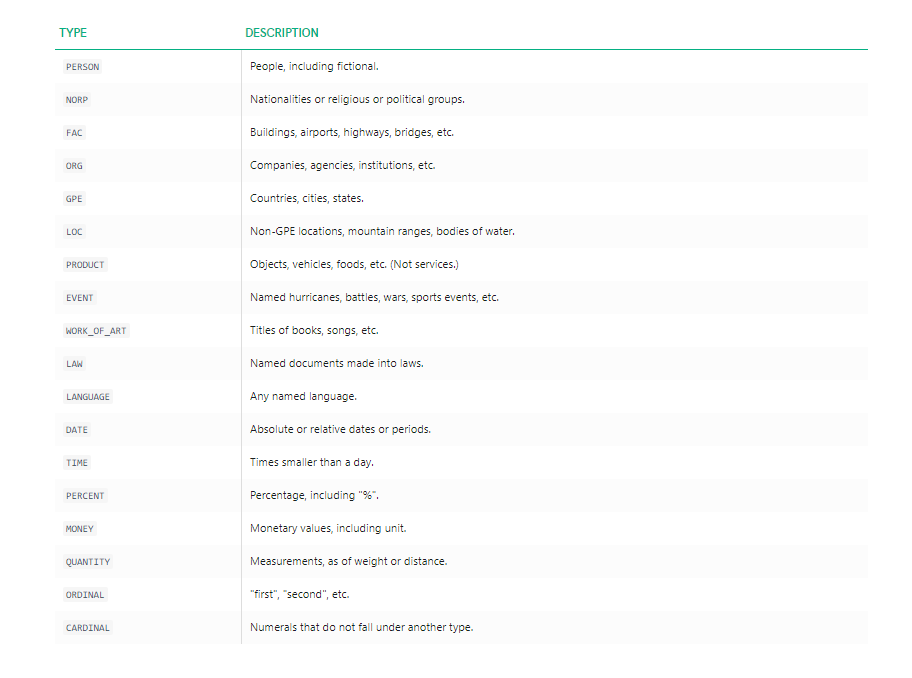

In [24]:
from IPython.display import Image
Image("img/picture.png")

In [25]:
import spacy
from spacy import displacy
from collections import Counter
import en_core_web_sm

nlp = en_core_web_sm.load(raw=False)

C:\Users\tshrs\Anaconda3\lib\site-packages\msgpack_numpy.py:184: DeprecationWarning: encoding is deprecated, Use raw=False instead.
  return _unpackb(packed, **kwargs)
C:\Users\tshrs\Anaconda3\lib\site-packages\msgpack_numpy.py:184: DeprecationWarning: encoding is deprecated, Use raw=False instead.
  return _unpackb(packed, **kwargs)
C:\Users\tshrs\Anaconda3\lib\site-packages\msgpack_numpy.py:184: DeprecationWarning: encoding is deprecated, Use raw=False instead.
  return _unpackb(packed, **kwargs)
C:\Users\tshrs\Anaconda3\lib\site-packages\msgpack_numpy.py:184: DeprecationWarning: encoding is deprecated, Use raw=False instead.
  return _unpackb(packed, **kwargs)
C:\Users\tshrs\Anaconda3\lib\site-packages\msgpack_numpy.py:184: DeprecationWarning: encoding is deprecated, Use raw=False instead.
  return _unpackb(packed, **kwargs)
C:\Users\tshrs\Anaconda3\lib\site-packages\msgpack_numpy.py:184: DeprecationWarning: encoding is deprecated, Use raw=False instead.
  return _unpackb(packed, **

In [213]:
#removing duplicates

# final_text = df['final_text'].unique()
final_text = df['Query Text']

print('Number of Query Text: ', len(final_text))

Number of Query Text:  74819


In [214]:
corpus = list(nlp.pipe(final_text))
#2153 russia china india
#726 google
#764 google vs microsoft tabular model

In [215]:
s = 'google'

for i,doc in enumerate(corpus):
    for word in doc:
        if str(word)==s:
            print(i,doc)

764 google vs microsoft tabular model
872 microsoft vs google
2185 google gsute
2910 google security
3399 google vision
3402 google amazon facebook
3990 google apps versus office 365; a 'cosmo- style' quiz
4366 google apps for work
4700 office vs google doc
4736 google doc
4974 multiple calendar google office 365
5546 google education
6148 google new hire onboarding doc
8425 google x microsoft
8514 google big query vs microsoft tabular model
8619 ai google
10717 box vs google drive
12334 toolkit: evaluation framework for google g suite and microsoft office 365
12514 google gsuite
12634 what it needs to know about google g suite:
12682 what it needs to know about google g suite: features and functionality
12689 google g suite
13257 google mobile device management
13603 google suite market share
13690 google vs ssas
13847 quadrant google cloud
14028 microsoft versus google
14256 aws, google cloud platform and microsoft azure
14975 survival guide to evaluating and implementing google g su

In [216]:
doc = corpus[2071]
print(doc)
print()
for ent in doc.ents:
    print(ent.text,ent.label_)

it key metrics data to optimize it costs



In [30]:
# corpus

In [217]:
# Looking at number of times each ent appears in the total corpus
# nb. ents all appear as Spacy tokens, hence needing to cast as str

from collections import defaultdict

all_ents = defaultdict(int)

for i, doc in enumerate(corpus):
    #print(i,doc)
    for ent in doc.ents:
        all_ents[str(ent)] += 1
        #print(ent)
        
print('Number of distinct entities: ', len(all_ents))

Number of distinct entities:  6099


In [219]:
# labels = [x.label_ for x in corpus.ents]
# Counter(labels)

ent_label = []
ent_common = []

for i, doc in enumerate(corpus):
    for ent in doc.ents:
        ent_label.append(ent.label_)
        ent_common.append(ent.text)
        
print("Unique labels for entities : ", Counter(ent_label))

Unique labels for entities :  Counter({'ORG': 4781, 'DATE': 3326, 'CARDINAL': 2791, 'GPE': 881, 'PERSON': 861, 'NORP': 266, 'ORDINAL': 170, 'PRODUCT': 94, 'WORK_OF_ART': 79, 'LOC': 79, 'PERCENT': 44, 'FAC': 31, 'LAW': 21, 'EVENT': 20, 'QUANTITY': 17, 'TIME': 15, 'MONEY': 5, 'LANGUAGE': 2})


In [220]:
sentences = []

for i, doc in enumerate(corpus):
    for ent in doc.sents:
        sentences.append(ent)

print(sentences[0])

adopt 10 best practices to become a contract negotiation expert for data integration tools


In [224]:
# Most popular ents

import operator

sorted_ents = sorted(all_ents.items(), key=operator.itemgetter(1), reverse=True)
sorted_ents[:100]


[('2018', 1451),
 ('2017', 294),
 ('365', 268),
 ('10', 266),
 ('china', 218),
 ('2019', 184),
 (' ', 182),
 ('five', 133),
 ('China', 132),
 ('5', 114),
 ('four', 97),
 ('three', 97),
 ('2016', 93),
 ('1', 92),
 ('2', 83),
 ('3', 77),
 ('one', 62),
 ('b2b', 59),
 ('\t', 58),
 ('4', 56),
 ('Critical Capabilities', 55),
 ('eight', 53),
 ('Cloud', 53),
 ('i&t', 51),
 ('six', 51),
 ('4.0', 50),
 ('Five', 48),
 ('Three', 48),
 ('2030', 45),
 ('Digital Business', 44),
 ('2020', 43),
 ('Digital', 42),
 ('Gartner', 42),
 ('first', 42),
 ('two', 41),
 ('seven', 40),
 ('third', 37),
 ('SAP', 37),
 ('Microsoft', 36),
 ('ten', 35),
 ('2015', 34),
 ('india', 34),
 ('2.0', 32),
 ('first 100 days', 32),
 ('Four', 31),
 ('RFP', 31),
 ('Strategic Roadmap', 30),
 ('7', 29),
 ('360', 29),
 ('annual', 28),
 ('100', 28),
 ('DevOps', 27),
 ('8', 27),
 ('2025', 27),
 ('i&o', 27),
 ('CIO', 27),
 ('6', 26),
 ('Build', 26),
 ('3rd', 25),
 ('Template', 24),
 ('Current Year', 23),
 ('2014', 22),
 ('multiyear', 2

### List of geographies and organizations being mentioned in the search terms.																									

In [225]:
for i, doc in enumerate(corpus):
    for ent in doc.ents:
        if ent.label_ == 'ORG' or ent.label_ == 'GPE':
            print(i, ent.text, ent.start_char, ent.end_char, ent.label_)

18 Unlock Mobile Digital Business Opportunities Using Enterprise Mobility Management Capabilities 0 94 ORG
68 Aerospace and Defense Context 0 29 ORG
120 EA Project Review Template 0 26 ORG
134 Office Support Cycles 38 59 ORG
134 Microsoft 69 78 ORG
135 Real Estate Agents 11 29 ORG
178 Digital 10 17 ORG
191 NGA Human Resources 0 19 ORG
245 the Insurance Customer Experience Will Require an IT Overhaul 10 71 ORG
254 M Europe Uses 1 14 ORG
254 Capabilities, Performance Management 45 81 ORG
259 Better Understanding of Business Ecosystems 20 63 ORG
275 ARIS 16 20 ORG
298 Equifax 0 7 ORG
332 Workday Human Capital Management Service Providers 17 67 ORG
346 Migrate 22 29 ORG
346 Windows 10 Using 33 49 ORG
347 SAP 22 25 ORG
352 Increasing & Sustaining Enterprise Social Collaboration & Networking Success Stories 0 84 ORG
380 Mobile Printing Solution (Phone/Tablet/Laptop 0 45 ORG
380 Market 54 60 GPE
389 OnDemand 7 15 GPE
455 China 0 5 GPE
455 Mobile 43 49 GPE
461 Red Team 35 43 ORG
471 Project Ma

4109 Market Guide for Operational Technology Security 0 48 ORG
4161 Supply Chain Planning 70 91 ORG
4194 27001:2013 4 14 ORG
4228 china 59 64 GPE
4230 Cisco UCS 27 36 ORG
4254 QA and Change Managment/Release 13 44 ORG
4268 Digital Business Success 55 79 ORG
4358 Integrate Cloud 7 22 GPE
4358 On-Premises Applications 40 64 ORG
4392 Test Driven Development Team 28 56 ORG
4411 BonitaSoft BPM 16 30 ORG
4425 Roles & Responsibilities 49 73 ORG
4425 Navistar 75 83 GPE
4426 staf?ng 50 57 ORG
4509 Scale Up Management for Digital Business 22 62 ORG
4537 Gartner's Research 9 27 ORG
4542 China 0 5 GPE
4542 Account 67 74 GPE
4548 China 0 5 GPE
4548 Building Responsive Data Management 28 63 ORG
4562 Workforce 33 42 GPE
4576 g00337823 0 9 GPE
4580 Sophos 0 6 ORG
4595 China 0 5 GPE
4607 Clarity Version 23 38 ORG
4639 Maverick 0 8 ORG
4654 Wanted Template 5 20 ORG
4654 Anti-Virus Testing 22 40 ORG
4668 Digital Marketing Capabilities Roadmap 29 67 ORG
4690 Digital Business 20 36 ORG
4690 Rich Media 38 4

8654 Digital Workplace 62 79 ORG
8680 i&t 14 17 GPE
8697 Application - Options 16 37 ORG
8711 Egnyte 0 6 GPE
8734 China 0 5 GPE
8734 Intelligent Things' 73 92 ORG
8756 china 0 5 GPE
8763 Telco 75 80 GPE
8764 r&r 11 14 ORG
8807 Industry Visions for Digital Business Set the Terms of Competition 0 66 ORG
8830 China 0 5 GPE
8830 Digital Business Ambition 28 53 ORG
8830 Transform 55 64 ORG
8839 Industrial Control Systems/SCADA 0 32 ORG
8846 r&r 5 8 GPE
8852 Create Persistent Data Value 11 39 ORG
8865 Re)Charter Template 38 57 ORG
8882 Kaspersky Total Security For Business 0 37 ORG
8887 Mitigate Security and Operational Risks 27 66 ORG
8920 Creating Disruptive Digital Strategies 14 52 ORG
9024 CASEwise Systems 0 16 ORG
9089 China 0 5 GPE
9089 Customer-Centric Organizations 45 75 ORG
9098 Insurance 20 29 GPE
9098 the Foundation of Your Automation Strategy 33 75 ORG
9128 RFP 0 3 ORG
9128 Social Media Engagement Applications for CRM Customer Service 13 74 ORG
9157 Determine Warehouse Operationa

12660 Digital Transformation 26 48 ORG
12672 Ignition Guide 0 14 ORG
12672 Request 29 36 GPE
12681 SharePoint 6 16 ORG
12681 Pitfalls 29 37 ORG
12698 MS Dynamics AX 0 14 ORG
12724 Creating Process-Focused Security Roles 19 58 ORG
12750 Digital 18 25 ORG
12781 Business Transformation Through Technology Innovation 8 61 ORG
12785 Level3 Executive 14 30 ORG
12786 Digital 36 43 ORG
12789 FMCG Business Architecture 49 75 ORG
12849 china 0 5 GPE
12874 china 0 5 GPE
12928 Let Artificial Intelligence's Immaturity Stop 6 51 ORG
12928 Gartner Trend Insight Report 84 112 ORG
12948 The California Department of Corrections and Rehabilitation Realigns IT Jobs with Required Technology Skills 0 108 ORG
12969 Dimensions of Business Ecosystems Enable the Digital Age 6 62 ORG
12971 Interview Questions/ 5 25 ORG
12976 china 0 5 GPE
12993 Palo Alto 0 9 GPE
12993 Real World Performance 29 51 ORG
13002 Exploit Digital Business Opportunities 29 67 ORG
13032 Application Development Strategies 0 34 ORG
13032 Dig

19017 Minimize 0 8 GPE
19017 Maximize 10 18 GPE
19017 Optimize 20 28 ORG
19022 Kotlin 8 14 GPE
19034 Dayforce 0 8 ORG
19040 Software Development & Support Contract Template 0 48 ORG
19042 700/22 11 17 ORG
19069 CDN 0 3 ORG
19070 Shared-Service Organization Onboarding Guide for Government 2 61 ORG
19075 EA Program 65 75 ORG
19083 Next for Retail Loyalty Programs 51 83 ORG
19112 Missing Components of Hardware Asset Management Strategies Are First Steps 0 74 ORG
19113 Analytics Service Providers, Worldwide 35 73 ORG
19123 Ignition Guide to 0 17 ORG
19123 Vendor Contracts 29 45 ORG
19134 Intelligent Things 45 63 ORG
19143 Service Management: Options 22 49 ORG
19157 Cloud Services 48 62 ORG
19177 Robust Availability Solutions for Database Management Systems 14 75 ORG
19213 Differentiate Your Customer Service 20 55 ORG
19228 Micro 38 43 ORG
19228 Indoor Signage and Wearable Technology Providers' 80 129 ORG
19228 Success 130 137 ORG
19236 CIO 91 94 ORG
19248 China 0 5 GPE
19249 Problem Manage

27354 Self Service 0 12 ORG
27366 Digital-Grade Intelligence 39 65 ORG
27385 Commercial Credit Collateral Management System 0 46 ORG
27411 Software Asset Management - Outsourcing 0 39 ORG
27421 stardock.com 1 13 ORG
27439 b2b 0 3 GPE
27484 OneStream Software 0 18 ORG
27491 Success 44 51 ORG
27495 Data Masking Pros and Cons 0 26 ORG
27495 Delphix 31 38 GPE
27495 Informatica 43 54 GPE
27495 Finance 58 65 GPE
27552 an Enterprise Architect 49 72 ORG
27557 china 0 5 GPE
27628 Application Management 28 50 ORG
27630   16 17 ORG
27634 China 0 5 GPE
27700 Market Guide for Data Center 0 28 ORG
27739 Digital Business: 17 34 ORG
27739 Navigating Digital Business Transformation Interdependencies 35 95 ORG
27740 Human Capital Management Applying AI 16 52 ORG
30092 Government Perspective 35 57 ORG
30109 b2b 0 3 GPE
30116 b2b 0 3 GPE
30122 Gartner 49 56 ORG
30122 ITScore 59 66 ORG
30122 Applications 71 83 ORG
30185 Primavera Platform 41 59 ORG
30232 Ipad 28 32 GPE
30232 VPN SSL 60 67 ORG
30232 Microso

37858 Expense System 14 28 ORG
37869 Automate Knowledge Management With Data Science to Enable the Learning Organization 0 83 ORG
37890 Access Bank 0 11 ORG
37907 Solenis CIO 0 11 ORG
37907 CMO Partner 16 27 ORG
37908 india 7 12 GPE
37919 the Office of the Chief Data Officer 48 84 ORG
37928 Artificial Intelligence Strategy 9 41 ORG
37928 Gartner Trend Insight Report 45 73 ORG
37949 Ignition Guide to 0 17 ORG
37949 Creating Infrastructure Scorecards 18 52 ORG
37955 SOX / Audit 0 11 ORG
38003 Digital Government 2030 0 23 ORG
38003 Ecosystem 67 76 GPE
38032 Leaders Across the Organization 0 31 ORG
38040 Life Sciences 21 34 ORG
38046 Unified Retail Commerce Primer 34 64 ORG
38067 HPE (Hewlett Packard Enterprise 0 31 ORG
38098 Azure Active 0 12 ORG
38100 Master Data Management 17 39 ORG
38107 Case Management Products for Charities and Foundation 8 61 ORG
38108 CSP Cybersecurity Opportunities Could Increase With New Technology Implementations 36 118 ORG
38124 Digital 24 31 ORG
38132 USB 10 1

45141 Drive Business Value 50 70 ORG
45165 Put Users in Charge of Enterprise Security 48 90 ORG
45182 Digital Business 35 51 ORG
45187 Synchronized Mass Email Distribution Solution 0 45 ORG
45229 Spain 19 24 GPE
45229 Portugal Perspective 29 49 ORG
45242 Ugly Truths of Postmodern ERP 7 36 ORG
45269 Updated 77 84 ORG
45286 china 0 5 GPE
45293 china 0 5 GPE
45301 china 0 5 GPE
45331 china 0 5 GPE
45355 Property Management 66 85 ORG
45380 Finance Moving 0 14 ORG
45380 Cloud 22 27 GPE
45388 Mastering Master Data Management 0 32 ORG
45391 Digital Web Content 13 32 ORG
45391 Digital Commerce 48 64 ORG
45392 BICC 48 52 GPE
45393 the Public Sector 40 57 ORG
45429 siem\ 0 5 GPE
45442 China 0 5 GPE
45444 Machine Learning Without Hiring (More) 6 44 ORG
45451 china 0 5 GPE
45459 Consolidation of Service Desk/End-User Computing 0 48 ORG
45477 Set Your Ecosystem Up 7 28 ORG
45480  62 63 ORG
45492 Prophix 0 7 GPE
45533 china 0 5 GPE
45539 NOSQL 78 83 ORG
45561 n1c 0 3 ORG
45583 GDPR Challenges 35 50

50635 	 2 3 ORG
50637 Business Capability Modeling Brings Clarity 0 43 ORG
50637 Insight 48 55 ORG
50660 Business Sponsors (Capital Group 28 60 ORG
50663 Identify Data Management Issues 9 40 ORG
50663 Moving Data 48 59 ORG
50663 Cloud 75 80 GPE
50669 Cloud Service Brokerage 17 40 ORG
50705 Run Decisive Proofs of Concept for Hyperconverged Integrated Systems 7 75 ORG
50710 Self-Service BI Tools 0 21 ORG
50732 JBOSS 22 27 ORG
50732 MuleSoft 32 40 ORG
50787 Drive Education 42 57 ORG
50787 Standardization 62 77 GPE
50787 Transportation 95 109 ORG
50790 Microsoft Office 0 16 ORG
50790 Initial and Renewal Negotiation Leverage 54 94 ORG
50798 Build an Effective API Security Strategy 7 47 ORG
50828 the Future of Workforce Management 21 55 ORG
50829 Build 65 70 ORG
50829 the Platform Business Operating Model' 71 109 ORG
50832 Security) Design Authority 16 42 ORG
50854 Network Operations Center 26 51 ORG
50861 Rockwell Automation 0 19 ORG
50863 SAP 5 8 ORG
50863 Acquisition of CallidusCloud Mean

57214 Grant Management Solution 43 68 ORG
57219 Create Digital Workplaces 63 88 ORG
57237 Mobile 15 21 GPE
57237 Endpoint 23 31 ORG
57261 Fleet Management Software Solution 0 34 ORG
57297 Wanted Template 5 20 ORG
57302 Ignition Guide to Developing 0 28 ORG
57342 Knowledge Management 0 20 ORG
57342 Your Customer Self-Service 31 57 ORG
57344 Best Practices 0 14 ORG
57363 Digital Business Optimization 21 50 ORG
57374 Vendor Guide 16 28 ORG
57375 Adapt Your Enterprise's Operating Model or Risk Failure 0 55 ORG
57375 Digital Business Strategy 64 89 ORG
57377 Microsoft Azure Services 0 24 ORG
57377 Before Committing to Azure 52 78 ORG
57381 SAP 0 3 ORG
57381 Cloud Platform Integration Services 4 39 ORG
57384 PCI 9 12 ORG
57395 CARTA 29 34 ORG
57397 Time 0 4 ORG
57410  Csat 21 26 ORG
57432 GDPR - Toolkits 0 15 ORG
57454 Operations 44 54 ORG
57456 Market Guide for Enterprise Data Loss Prevention 0 48 ORG
57471 Digital Disruption Profile 0 26 ORG
57476 Implementing Enterprise Architecture Tools

62047 Public Safety and Criminal Justice 21 55 ORG
62066 the Right Intelligent Business Process Management 34 83 ORG
62069 Mobile 16 22 GPE
62088 china 0 5 GPE
62105 Adapt Project Change Management 0 31 ORG
62108 PULA - Oracle Contract Model 0 28 ORG
62128 China 0 5 GPE
62136 CIO 31 34 ORG
62140 Microsoft 12 21 ORG
62140 Cloud Enrollment Volume Licensing Program 35 76 ORG
62145 Midmarket Context 0 17 ORG
62145 IT Financial Management Tool Initiatives' 45 86 ORG
62147 China 0 5 GPE
62147 These Recommended Life Spans 32 60 ORG
62160 The Future of Work and Talent: Culture, Diversity, Technology 0 61 ORG
62167 Focus on Business Outcomes 0 26 ORG
62168 CIO 31 34 ORG
62169 Procurement Applications Primer 24 55 ORG
62170 Emerging Technology Spotlight 0 29 ORG
62176 Market Guide for Endpoint Detection and Response Solutions 0 58 ORG
62185 Sap Hybris B2B 0 14 ORG
62188 Application Rationalization's 10 39 ORG
62198 b2b 17 20 GPE
62199 Managed Workplace Services 19 45 ORG
62203 Digital Business T

66885 Enrich Professional Development Through a Continuous-Learning Culture 0 69 ORG
66898 Organize Digital Security 7 32 ORG
66909 RFP Template for Selecting a Software Reseller 9 55 ORG
66922 Worst EA Practices 13 31 ORG
66922 the Digital Business Era 59 83 ORG
66927 the Right Technology for Modern Meeting Rooms 7 52 ORG
66948 Reallocating EA Resources 31 56 ORG
66957 Outcomes for Investments 32 56 ORG
66957 Digital Business 60 76 ORG
66975 Outcomes 42 50 ORG
66975 Digital Ecosystems 54 72 ORG
66986 Retaining IT Employees: Engage Them 14 49 ORG
67019 ASG Technologies 0 16 ORG
67059 Digital Workplace Applications Primer 0 37 ORG
67069 Reimagining Security 0 20 ORG
67069 IT Resilience 25 38 ORG
67069 Cloud-Native DevSecOps World 45 73 ORG
67071 The Gartner Supply Chain Top 0 28 ORG
67081 Digital Technology Trends 13 38 ORG
67091 Digital Workplace 53 70 ORG
67094 Records Management in Office 54 82 ORG
67115 Market Guide for Enterprise Legal Management Solutions 0 54 ORG
67116 Defining Q

71237 Managed Workplace Services 19 45 ORG
71242 Digital Transformation (Monsanto Company 8 48 ORG
71243 South Korea Perspective 19 42 ORG
71245 Digital Business 43 59 ORG
71246 Application and Data Security 16 45 ORG
71247 App Development Platforms 33 58 ORG
71250 CIO Mastery of Leadership 0 25 ORG
71250 People Dynamics Primer 39 61 ORG
71253 Gartner 32 39 GPE
71260 U.S. Department of Defense 4 30 ORG
71268 Contact Centre Design 8 29 ORG
71269 Institute Cybersecurity 0 23 ORG
71270 High-Impact Reference Architectures 43 78 ORG
71271 CommVault V11 6 19 ORG
71271 Cloud 37 42 GPE
71279 AI / Textual Analysis / Machine Learning 0 40 ORG
71279 Watson, Cognitive Services 42 68 ORG
71280 Decision Intelligence Is the Near Future of Decision 0 52 ORG
71280 Gartner Trend Insight Report 63 91 ORG
71287 Digital Business 60 76 ORG
71289 Agile Mindset Are Required 41 67 ORG
71296 Market Guide for Higher Education Catalog 0 41 ORG
71296 Curriculum Management Solutions 46 77 ORG
71312 Management Appro

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



## Stanford NER tagging

http://nlp.stanford.edu:8080/ner/process

In [87]:
import os
java_path = "C:/Program Files (x86)/Common Files/Oracle/Java/javapath/java.exe"
os.environ['JAVAHOME'] = java_path

In [88]:
os.environ['JAVAHOME']

'C:/Program Files (x86)/Common Files/Oracle/Java/javapath/java.exe'

In [89]:
import nltk
nltk.internals.config_java('C:/Program Files (x86)/Common Files/Oracle/Java/javapath/java.exe')

In [ ]:
# corpus = list(df['final_tokenized'])

In [208]:
%%time

from nltk.tag.stanford import StanfordNERTagger
from nltk.tokenize import word_tokenize

def formatted_entities(classified_paragraphs_list):
    entities = {'persons': list(), 'organizations': list(), 'locations': list()}

    for classified_paragraph in classified_paragraphs_list:
        for entry in classified_paragraph:
            entry_value = entry[0]
            entry_type = entry[1]

            if entry_type == 'PERSON':
                entities['persons'].append(entry_value)

            elif entry_type == 'ORGANIZATION':
                entities['organizations'].append(entry_value)

            elif entry_type == 'LOCATION':
                entities['locations'].append(entry_value)

    return entities

tagger = StanfordNERTagger('/Users/tshrs/NER/stanford-ner/classifiers/english.all.3class.distsim.crf.ser.gz',
               '/Users/tshrs/NER/stanford-ner/stanford-ner.jar',
               encoding='utf-8')


C:\Users\tshrs\Anaconda3\lib\site-packages\nltk\tag\stanford.py:201: DeprecationWarning: 
The StanfordTokenizer will be deprecated in version 3.2.6.
Please use nltk.parse.corenlp.CoreNLPParser instead.
  super(StanfordNERTagger, self).__init__(*args, **kwargs)


Wall time: 1.96 ms


In [210]:
%%time

tokenized_paragraphs = list()

# for text in paragraphs:
for i,text in enumerate(corpus[0:500]):
#     print(i,text)
    tokenized_paragraphs.append(word_tokenize(str(text)))


Wall time: 72.8 ms


In [226]:
# %%time

# classified_paragraphs_list = []

# # Run NER tagger on words
# for ent in tokenized_paragraphs:
# #    print(ent)
#     classified_paragraphs_list.append(tagger.tag(ent))

In [192]:
%%time

#print(classified_paragraphs_list)

formatted_result = formatted_entities(classified_paragraphs_list)
print(formatted_result)

{'persons': [], 'organizations': [], 'locations': []}
Wall time: 2 ms


## Core NLP NER tagging

In [227]:
%%time

final_text = df['Query Text']
corpus = list(final_text)

tokenized_paragraphs = []

# for text in paragraphs:
for i,text in enumerate(corpus):
#     print(i,text)
    tokenized_paragraphs.append(word_tokenize(str(text)))

tagged_words = []

for ent in tokenized_paragraphs:
    tagged_words.append(nltk.pos_tag(ent))

Wall time: 46.2 s


In [188]:
# print(tagged_words[0:100])

In [228]:
%%time

ne_tagged = []

for tag in tagged_words:
    ne_tagged.append(nltk.ne_chunk(tag))


Wall time: 1min 2s


In [248]:
pprint.pprint(ne_tagged[759])
print()

for t in ne_tagged[759]:
    print("Inside t",t)
    for i in t:
        print("Inside i : ",i)
    break

Tree('S', [Tree('GPE', [('China', 'NNP')]), ('Summary', 'NNP'), ('Translation', 'NN'), (':', ':'), ("'CIOs", 'NN'), Tree('PERSON', [('Must', 'NNP'), ('Build', 'NNP'), ('Greater', 'NNP'), ('Business', 'NNP'), ('Acumen', 'NNP')]), ('in', 'IN'), ('IT', 'NNP'), ('for', 'IN'), Tree('ORGANIZATION', [('Digital', 'NNP'), ('Business', 'NNP')]), ("'", 'POS')])

Inside t (GPE China/NNP)
Inside i :  ('China', 'NNP')
